# DM - Clustering analysis [TASK 2]

Explore the dataset using various clustering techniques.

Library imports and initial settings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

from pyclustering.cluster import cluster_visualizer, cluster_visualizer_multidim
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

from utils import fetch_preprocessed_dataset, store_preprocessed_dataset, build_grid_plot

import sys
import logging as lg

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

Fetching users dataset saved in data preparation phase.

In [2]:
# Load the users dataset from pickle
dataset = fetch_preprocessed_dataset(step_name="users_total")
users = dataset['users.pickle']

`users_num` is a dataset composed by numerical attributes of `users`.

In [3]:
users_num_cols = ['statuses_count', 'bot', 'tweets_num', 'tweets_2020_num', 'likes_num', 'comments_num', 'entropy', 'ratio_likes_x_tweets', 'texts_mean_length', 'texts_special_chars_length']
users_num = users[users_num_cols].astype({'bot': 'int64'})

users_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   statuses_count              11508 non-null  int64  
 1   bot                         11508 non-null  int64  
 2   tweets_num                  11508 non-null  int64  
 3   tweets_2020_num             11508 non-null  int64  
 4   likes_num                   11508 non-null  float64
 5   comments_num                11508 non-null  float64
 6   entropy                     11508 non-null  float64
 7   ratio_likes_x_tweets        11508 non-null  float64
 8   texts_mean_length           11508 non-null  float64
 9   texts_special_chars_length  11508 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 989.0 KB


## Scaling phase

It's used `MinMaxScaler` to rescale all numerical numbers between 0 and 1

In [4]:
scaler = MinMaxScaler()
scaler.fit(users_num.values)

MinMaxScaler()

Using transform function we are able to scale our values. Scaler is useful also for the inverse transformation.

In [5]:
users_num_scaled = scaler.transform(users_num.values)

users_num_scaled

array([[1.90211610e-04, 1.00000000e+00, 2.98089172e-02, ...,
        2.91380883e-05, 2.49684830e-01, 1.89594009e-02],
       [1.35150355e-04, 0.00000000e+00, 2.62420382e-02, ...,
        3.96726279e-05, 2.76700572e-01, 1.70393560e-02],
       [7.50835304e-06, 1.00000000e+00, 5.09554140e-04, ...,
        0.00000000e+00, 5.92286501e-02, 2.01550388e-02],
       ...,
       [1.50167061e-05, 0.00000000e+00, 1.27388535e-03, ...,
        0.00000000e+00, 2.67217631e-01, 3.10077519e-02],
       [1.05116943e-04, 1.00000000e+00, 2.29299363e-02, ...,
        6.04535283e-05, 2.57515212e-01, 1.90646563e-02],
       [1.32121986e-02, 0.00000000e+00, 8.40764331e-01, ...,
        9.14517571e-05, 2.11121849e-01, 1.44240998e-02]])

## Base clustering

We use base clustering methods to analyze the `users` dataset.

### KMeans

Firstly we run kmeans algorithms several times and we create a list of SSE measures to understand which is the proper number to asign to k.

In [6]:
sse_list = []
max_k = 30
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(users_num_scaled)

    sse = kmeans.inertia_
    sse_list.append(sse)

We plot results below.

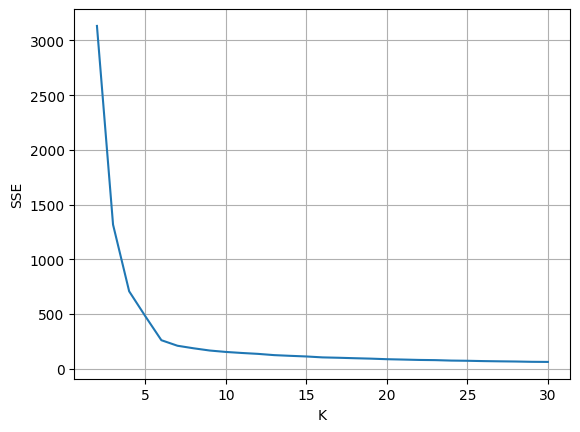

In [7]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.grid(True)
plt.show()

Now we build our model with the proper k and print different metrics to understand the goodness of our model.

In [8]:
kmeans = KMeans(n_clusters=6, n_init=10, max_iter=100)
kmeans.fit(users_num_scaled)

lg.info(f'SSE: {kmeans.inertia_}')
lg.info(f'Silhouette: {silhouette_score(users_num_scaled, kmeans.labels_)}')
lg.info(f'Separation {metrics.davies_bouldin_score(users_num_scaled, kmeans.labels_)}')

2022-11-07 03:34:34,752 - root - INFO - SSE: 261.68067724413476
2022-11-07 03:34:36,459 - root - INFO - Silhouette: 0.7690495041545639
2022-11-07 03:34:36,466 - root - INFO - Separation 0.3816838870736689


Here we plot the distribution of labels among different clusters.

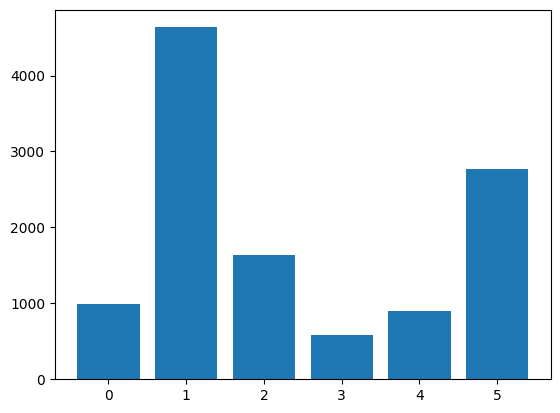

In [9]:
labels_distribution = np.unique(kmeans.labels_, return_counts=True)
plt.bar(labels_distribution[0], labels_distribution[1])
plt.show()

Parallel coordinates plot used to see distinguishability of clusters for each attribute.

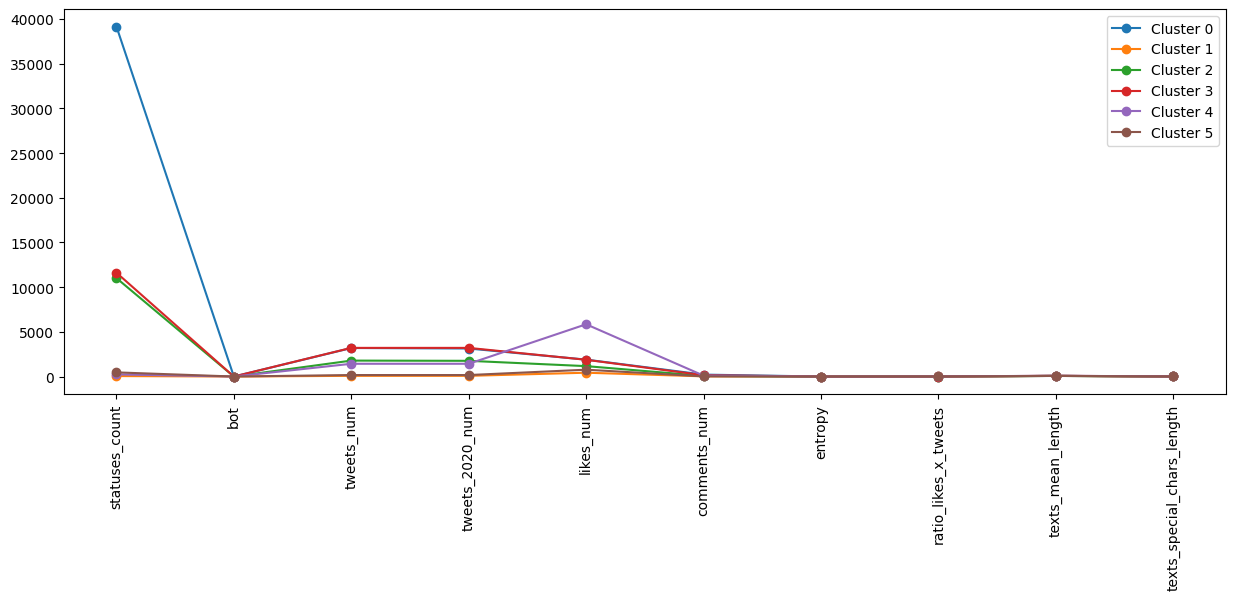

In [10]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

plt.figure(figsize=(15, 5))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label=f'Cluster {i}')
plt.xticks(range(0, len(users_num.columns)), users_num.columns, rotation=90)
plt.legend(fontsize=10)
plt.show()

Scatter-plots for some attribute couples.

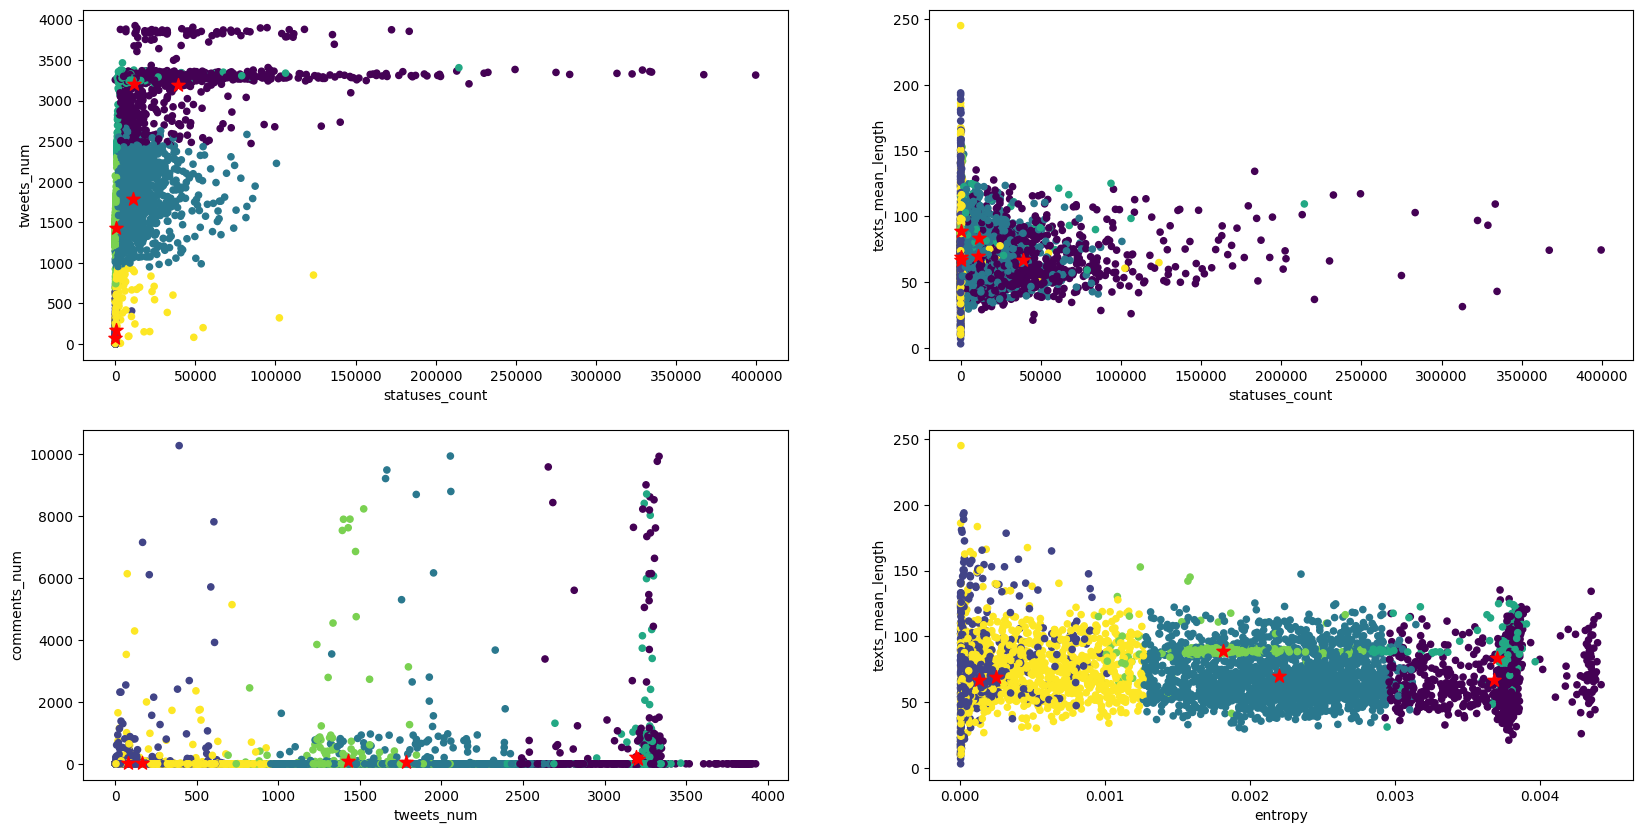

In [11]:
configs = [
    {
        'type': 'scatter',
        'df': users_num,
        'labels': kmeans.labels_,
        'centers': centers,
        'x_index': 0,
        'y_index': 2,
    },
    {
        'type': 'scatter',
        'df': users_num,
        'labels': kmeans.labels_,
        'centers': centers,
        'x_index': 0,
        'y_index': 8,
    },
    {
        'type': 'scatter',
        'df': users_num,
        'labels': kmeans.labels_,
        'centers': centers,
        'x_index': 2,
        'y_index': 5,
    },
    {
        'type': 'scatter',
        'df': users_num,
        'labels': kmeans.labels_,
        'centers': centers,
        'x_index': 6,
        'y_index': 8,
    },
]

build_grid_plot(configs=configs)

Bar plot able to show categorical attribute distribution among clusters.

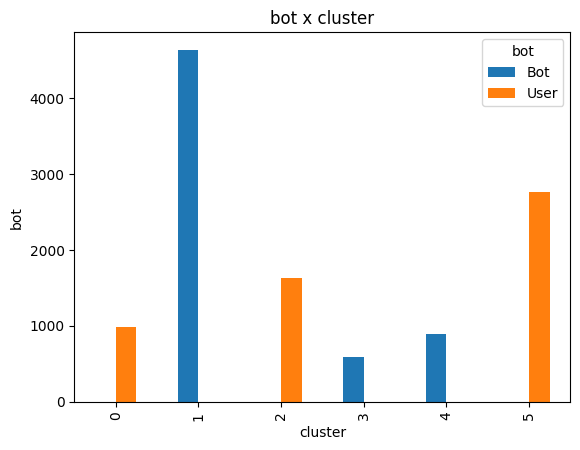

In [12]:
users_pct = pd.crosstab(kmeans.labels_, users_num['bot'].map(lambda x: 'Bot' if x else 'User'))

users_pct.plot(kind='bar', stacked=False, title='bot x cluster')
plt.xlabel('cluster')
plt.ylabel('bot')
plt.show()

### DBSCAN

Here we compute the pairwise distances among `users_num`.

In [13]:
# pair wise distance
dist = pdist(users_num, 'euclidean')
# transformation of distance in square form
dist = squareform(dist)

lg.info(dist)

2022-11-07 03:34:40,184 - root - INFO - [[   0.           30.34655831  184.19661352 ...  173.31680376
    51.25030176 6893.66608197]
 [  30.34655831    0.          160.65546997 ...  146.84103311
    22.55541273 6923.14842975]
 [ 184.19661352  160.65546997    0.         ...   50.66447364
   139.19646658 7055.76776104]
 ...
 [ 173.31680376  146.84103311   50.66447364 ...    0.
   125.78996058 7050.63805736]
 [  51.25030176   22.55541273  139.19646658 ...  125.78996058
     0.         6944.08079211]
 [6893.66608197 6923.14842975 7055.76776104 ... 7050.63805736
  6944.08079211    0.        ]]


In [14]:
k = 100
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

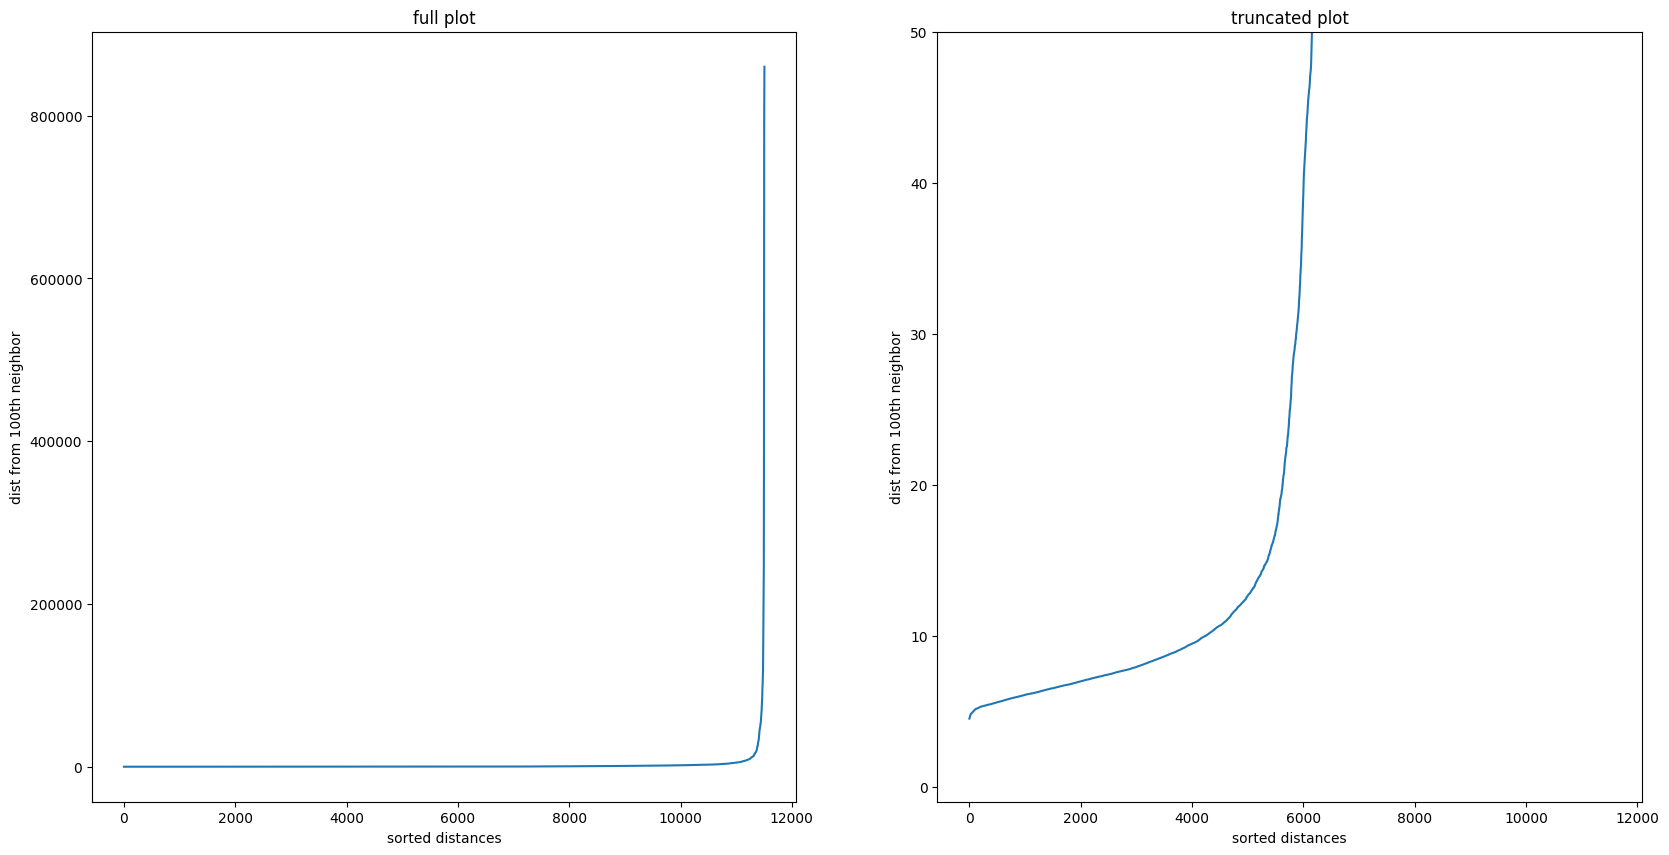

In [15]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('full plot')
ax1.plot(range(0, len(kth_distances)), sorted(kth_distances))

ax2.set_title('truncated plot')
ax2.plot(range(0, len(kth_distances)), sorted(kth_distances))
ax2.set_ylim([-1, 50])

for ax in [ax1, ax2]:
    ax.set_ylabel(f'dist from {k}th neighbor')
    ax.set_xlabel('sorted distances')

plt.show()

In [16]:
dbscan = DBSCAN(eps=15, min_samples=k)
dbscan.fit(users_num_scaled)

lg.info(f'Silhouette {silhouette_score(users_num_scaled, kmeans.labels_)}')
lg.info(f'Separation {metrics.davies_bouldin_score(users_num_scaled, kmeans.labels_)}')

2022-11-07 03:34:50,960 - root - INFO - Silhouette 0.7690495041545639
2022-11-07 03:34:50,969 - root - INFO - Separation 0.3816838870736689


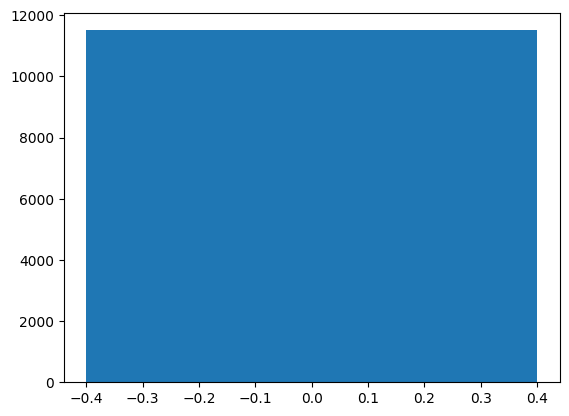

In [17]:
labels_distribution = np.unique(dbscan.labels_, return_counts=True)
plt.bar(labels_distribution[0], labels_distribution[1])
plt.show()

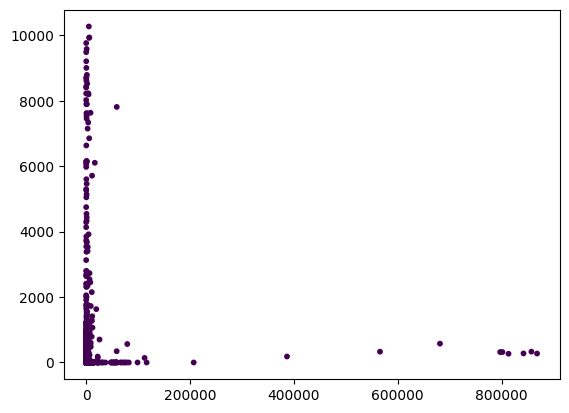

In [18]:
plt.scatter(users_num['likes_num'], users_num['comments_num'], c=dbscan.labels_, s=10)
plt.show()

### Hierarchical

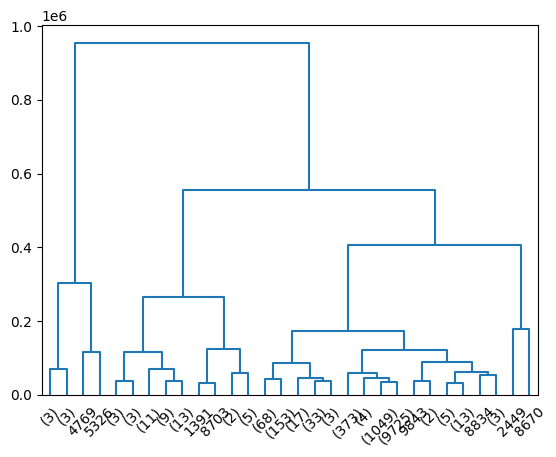

In [19]:
data_dist = pdist(users_num, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

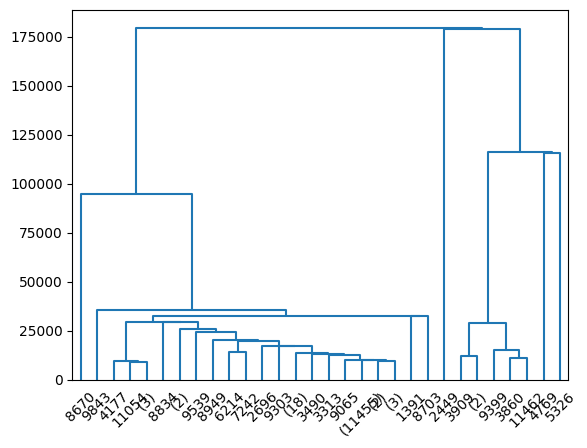

In [20]:
data_dist = pdist(users_num, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')

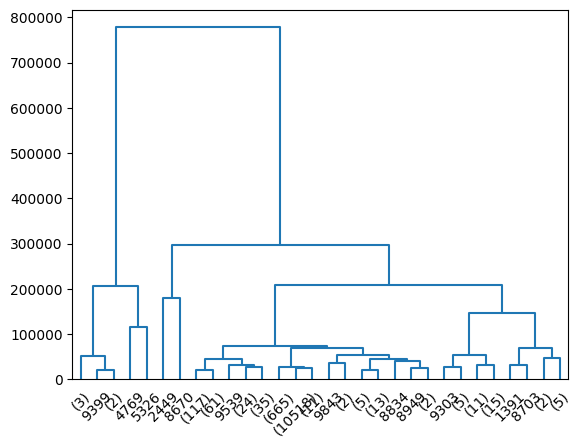

In [21]:
data_dist = pdist(users_num, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

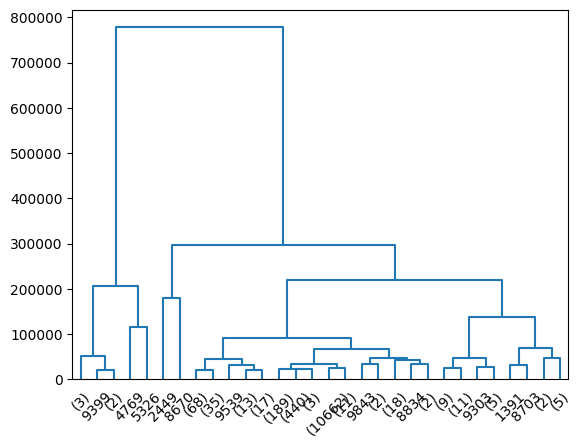

In [22]:
data_dist = pdist(users_num, metric='euclidean')
data_link = linkage(data_dist, method='centroid', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

## Advance clustering

### XMeans

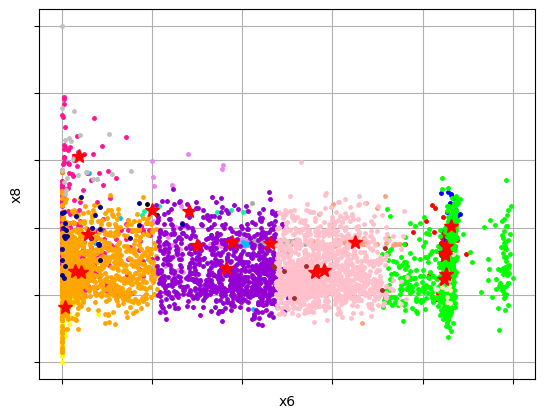

In [26]:
# amount of initial centers defines amount of clusters from which X-Means will start analysis
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(users_num_scaled, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters to the assigned max
xmeans_instance = xmeans(users_num_scaled, initial_centers, 20)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

# Visualize clustering results
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, users_num_scaled.tolist())
visualizer.append_cluster(centers, None, marker='*', markersize=10, color='r')
visualizer.show(pair_filter=[[6, 8]])